# 线性回归从零开始实现

标量形式$$\ell^{(i)}(w_1, w_2, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2,$$
向量的二次型有恒等式
$$\ell(\boldsymbol{\theta})=\frac{1}{2n}(\boldsymbol{\hat{y}}-\boldsymbol{y})^\top(\boldsymbol{\hat{y}}-\boldsymbol{y}).$$

- 注:$v^\top v = v^2$
- 梯度就是随着自变量变化，应变量变化最快的方向，大于0上升

参数迭代
$$
\begin{aligned}
w_1 &\leftarrow w_1 -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \frac{ \partial \ell^{(i)}(w_1, w_2, b)  }{\partial w_1} = w_1 -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}x_1^{(i)} \left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right),\\
w_2 &\leftarrow w_2 -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \frac{ \partial \ell^{(i)}(w_1, w_2, b)  }{\partial w_2} = w_2 -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}x_2^{(i)} \left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right),\\
b &\leftarrow b -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \frac{ \partial \ell^{(i)}(w_1, w_2, b)  }{\partial b} = b -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}\left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right).
\end{aligned}
$$
- 就是自变量减去梯度，让损失变小，上述公式可以表示为: $w_1 \leftarrow w_1 -   \frac{学习率}{|批次中样本数|}\sum_{i \in \mathcal{批次中样本数}}   \nabla_{\boldsymbol{w_1}} \ell^{(批次中样本数)}(\boldsymbol{w_1})$

In [9]:
%matplotlib inline
#  在笔记本里画图时加上它，图就会“贴”在代码下面显示；但在 .py 脚本里不要写
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random

In [29]:
num_input = 2
num_examples = 1000
true_w = [2, 3.4]
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_input)) #生成一个服从正态分布的随机特征矩
labels = true_w[0]*features[:, 0] + true_w[1]*features[:, 1] + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)#噪声

In [30]:
features[0],labels[0]

(
 [-1.0295794  -0.82544976]
 <NDArray 2 @cpu(0)>,
 
 [-0.6720682]
 <NDArray 1 @cpu(0)>)

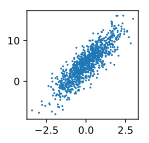

In [35]:
def use_svg_display():
    display.set_matplotlib_formats('svg')
def set_figsize(figsize=(2, 2)):
    use_svg_display()
    # 设置图片尺寸
    plt.rcParams['figure.figsize'] = figsize
set_figsize()
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1);


## 读取数据集

In [74]:

#遍历数据集读取小批量数据样本
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    #得到每个样本的索引
    indices = list(range(num_examples))     
    #打乱列表索引，相当于随机读取
    random.shuffle(indices)    
    for i in range(0, num_examples, batch_size): #对数据集进行切片
        j = nd.array(indices[i: min(i + batch_size, num_examples)])#得到小批量随机索引的数组
        yield features.take(j), labels.take(j) #根据索引返回对应元素

    
batch_size = 3
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break


[[ 0.23105703  1.4446224 ]
 [ 0.03777263 -1.0965194 ]
 [ 0.80692774  1.2087251 ]]
<NDArray 3x2 @cpu(0)> 
[9.578924  0.5440851 9.937456 ]
<NDArray 3 @cpu(0)>


## 定义模型

In [60]:
#初始化模型参数
w = nd.random.normal(scale= 0.01, shape= (num_input, 1))
b = nd.zeros(shape=(1,))

w.attach_grad()
b.attach_grad()

In [75]:
#在“神经网络”表述里，linreg就是：nn.Linear(d, m)
def linreg(X, w, b):
    return nd.dot(X, w) + b
#定义损失函数
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2/ 2
#定义优化算法
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size
    

## 训练模型

In [76]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(1, num_epochs + 1):
    for X, y in data_iter(batch_size , features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)
        l.backward() 
        sgd([w, b], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss: %f' % (epoch, train_l.mean().asnumpy()))


epoch 1, loss: 0.000052
epoch 2, loss: 0.000051
epoch 3, loss: 0.000051


In [69]:
#查看更新后的参数

print(true_w, w)
print(true_b, b)

[2, 3.4] 
[[2.0001357]
 [3.4003224]]
<NDArray 2x1 @cpu(0)>
4.2 
[4.199955]
<NDArray 1 @cpu(0)>


**反向传播后的梯度写入（对应 `w.grad`、`b.grad`）**

$$
\text{(after }\texttt{l.backward()}\text{):}\qquad
\texttt{w.grad} \;=\; \frac{\partial l}{\partial \mathbf w},\qquad
\texttt{b.grad} \;=\; \frac{\partial l}{\partial b}.
$$

**若批量损失为逐样本求和** \(l=\sum_{i=1}^{B}\ell_i\)

$$
l=\sum_{i=1}^{B}\ell_i
\;\Longrightarrow\;
\frac{\partial l}{\partial \mathbf w}
=\sum_{i=1}^{B}\frac{\partial \ell_i}{\partial \mathbf w},
\qquad
\frac{\partial l}{\partial b}
=\sum_{i=1}^{B}\frac{\partial \ell_i}{\partial b}.
$$

**对应的 SGD（再除以 \(B\) 做平均）**

$$
\mathbf w \leftarrow \mathbf w
- \eta\,\frac{1}{B}\,\frac{\partial l}{\partial \mathbf w},
\qquad
b \leftarrow b
- \eta\,\frac{1}{B}\,\frac{\partial l}{\partial b}.
$$

**若先对损失取均值** \(l=\frac{1}{B}\sum_{i=1}^{B}\ell_i\)

$$
l=\frac{1}{B}\sum_{i=1}^{B}\ell_i
\;\Longrightarrow\;
\texttt{w.grad} \,=\, \frac{1}{B}\sum_{i=1}^{B}\frac{\partial \ell_i}{\partial \mathbf w},
\qquad
\texttt{b.grad} \,=\, \frac{1}{B}\sum_{i=1}^{B}\frac{\partial \ell_i}{\partial b}.
$$

**此时 SGD 不再额外除以 \(B\)**

$$
\mathbf w \leftarrow \mathbf w
- \eta\,\frac{\partial l}{\partial \mathbf w},
\qquad
b \leftarrow b
- \eta\,\frac{\partial l}{\partial b}.
$$


In [85]:
test_1 = nd.random.normal(scale= 1,shape= (2,)) #（N， ）和（N， 1）不一样
test_2 = nd.random.normal(scale= 1,shape= (2,1))
print(test_1, test_2)


[-0.20085481  0.93426514]
<NDArray 2 @cpu(0)> 
[[-2.0971875]
 [-0.8413213]]
<NDArray 2x1 @cpu(0)>
